In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

# XAI for image data with Captum



[Captum](https://captum.ai/) ("comprehension" in Latin) is an open
source, extensible library for model interpretability built on PyTorch.

With the increase in model complexity and the resulting lack of
transparency, model interpretability methods have become increasingly
important. Model understanding is both an active area of research as
well as an area of focus for practical applications across industries
using machine learning. Captum provides state-of-the-art algorithms,
including Integrated Gradients, to provide researchers and developers
with an easy way to understand which features are contributing to a
model's output.

Full documentation, an API reference, and a suite of tutorials on
specific topics are available at the [captum.ai](https://captum.ai/)
website.

Introduction
------------


In this notebook, we'll look at Gradient-based methods, Perturbation methods and Local surrogate models.

Let's recall the main characteristics of these broad categories:

-   **Gradient-based algorithms** calculate the backward gradients of a
    model output with respect to the input to find the features that mostly influenced the prediction. Some examples are **Vanilla Gradient**, **Grad CAM** and **Integrated Gradients**.
-   **Perturbation-based algorithms** examine the changes in the output
    of a model in response to changes in the input.
    The input perturbations may be directed or random. **Occlusion,**
    **Feature Ablation,** and **Feature Permutation** are all
    perturbation-based algorithms available in Captum.
-   **Local surrogate models** train an interpretable model in the neighborhood of the given sample to mimicking the behaviour of the original model. The explanation is then derived from the feature importance of the surrogate model. **LIME** is an example of surrogate model available in Captum.  


We'll be examining algorithms of all types below.

Captum also provide several easy-to-employ visualization tools for explanation algorithms. While we have seen that it is possible to create our
own visualizations with Matplotlib, Captum offers enhanced tools specific to its attributions:

-   The `captum.attr.visualization` module (imported below as `viz`)
    provides helpful functions for visualizing attributions related to
    images.
-   **Captum Insights** is an easy-to-use API on top of Captum that
    provides a visualization widget with ready-made visualizations for
    image, text, and arbitrary model types.

Both of these visualization toolsets will be employed in this
notebook. We will focus on computer vision use
cases, but the Captum can be actually employed on different kind of data, e.g., image, text and tabular as well.


To install Captum in an Anaconda or pip virtual environment, use the
appropriate command for your environment below:

With `conda`:

``` {.sourceCode .sh}
conda install pytorch torchvision captum flask-compress matplotlib -c pytorch
```

With `pip` (required in Colab):

``` {.sourceCode .sh}
pip install torch torchvision captum matplotlib Flask-Compress
```


In [2]:
!pip install torch torchvision captum matplotlib Flask-Compress

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

As you see from above, after executing this cell the first time you need to **restart the session** to load the installed libraries


A First Example
---------------

To start, let's take a simple example. We'll again employ a ResNet
model pretrained on the ImageNet dataset. We'll get a test input, and
use the simple Vanilla Gradient algorithm that we previously implemented to examine how Captum works.  We will also employ Captum visualization tool to see a helpful visualization of this input attribution map for some test images.

First, some imports:


In [3]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import Occlusion, LayerGradCam, Saliency
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib

Now we'll use the TorchVision model library to download a pretrained
ResNet. Since we're not training, we'll place it in evaluation mode for
now.


In [4]:
model = models.resnet18(weights=models.ResNet50_Weights)
model = model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.8MB/s]


In the lab4-b.zip file from where you extract this notebook should also have some files (e.g., `cat.jpg`) in it. Place all the files in the same place where you are executing this notebook (or upload them if you are using Colab).


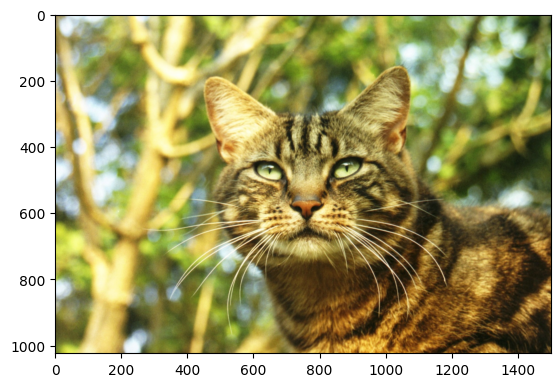

In [6]:
test_img = Image.open('cat.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()

Our ResNet model was trained on the ImageNet dataset, and expects images
to be of a certain size, with the channel data normalized to a specific
range of values. We'll also pull in the list of human-readable labels
for the categories our model recognizes - it should be among the unzipped files as well.


In [8]:
# model expects 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor(),

])
norm_transform = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225])

transformed_img = transform(test_img)
input_img = norm_transform(transformed_img)
input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

# we restore the transformed img to be a standard numpy array
orig_img = np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0))

labels_path = 'imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

Now, we can ask the question: What does our model think this image
represents?


In [9]:
output = model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: tabby ( 0.56882244348526 )


We've confirmed that ResNet thinks our image of a cat is, in fact, a
cat (a `tabby` cat, in particular, which is the most common type of domestic cat) . But *why* does the model think this is an image of a cat?

For the answer to that, we turn to Captum.


Gradient-based methods: Vanilla Gradient
=============================================

Saliency methods use a specific input - here, our test image - to generate
a map of the relative importance. In particular they all return a matrix $S \in \mathbb{R}^{H\times W}$ representing the positive importance of each input pixel to a given output class.


[Saliency](https://captum.ai/api/saliency.html) (i.e., Vanilla Gradient)
is one of the feature attribution algorithms available in Captum. However, most of them behave similarly (by calling the method `.attribute(input_img, target)`), with dedicated parameters to be tuned in some cases.

Once we have the importance map from Saliency, we'll use the
visualization tools in Captum to represent the
importance map. Captum's `visualize_image_attr()` function provides a
variety of options for customizing display of your attribution data.
Here we use it to plot both the original image and the attribution map. Note that the latter has to be converted to a numpy array following the standard image format $H\times W \times C$.


/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


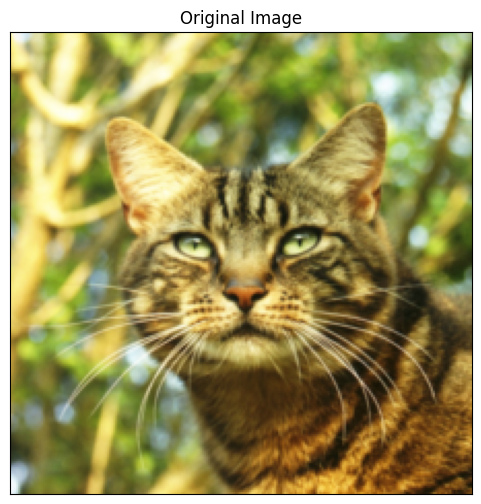

<ipython-input-10-a1beedd22584>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=matplotlib.cm.get_cmap('plasma'),


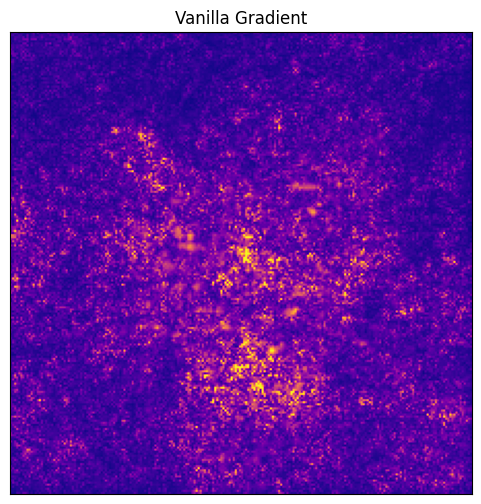

In [10]:
# Initialize the attribution algorithm with the model
vanilla_gradient = Saliency(model)

# Ask the algorithm to attribute our output target to the most important input pixels
attributions_vg = vanilla_gradient.attribute(input_img, target=pred_label_idx)

# Show the original image for comparison
_ = viz.visualize_image_attr(None, orig_img,
                      method="original_image", title="Original Image")

# Show vanilla-gradient
_ = viz.visualize_image_attr(np.transpose(attributions_vg.squeeze().cpu().detach().numpy(), (1,2,0)),
                             orig_img,
                             method="heat_map", title="Vanilla Gradient",
                             cmap=matplotlib.cm.get_cmap('plasma'),
)


In the image above, you should see that Vanilla Gradients gives us
most of the signal around the cat's location in the image, particularly around the muzzle.


### Let's try other visualization methods!

Captum provides several ways to visualize Saliency maps.
`viz.vizualize_image_attr` provides visual attribution for a given image by normalizing attribution values of the desired sign (positive, negative, absolute value, or all) and displaying them using the desired mode in a matplotlib figure.

The `method` argument is of particular importance as it allows to create nice overlaying of the attribution matrix with the original image.

    def visualize_image_attr(attr: ndarray, original_image: Union[None, ndarray]=None, method: str='heat_map',
        sign: str='absolute_value', ...)

    method (str, optional): Chosen method for visualizing attribution.
                Supported options are:
            1. `heat_map` - Display heat map of chosen attributions
            2. `blended_heat_map` - Overlay heat map over greyscale  
                   version of original image. Parameter alpha_overlay
                corresponds to alpha of heat map.
            3. `original_image` - Only display original image.
            4. `masked_image` - Mask image (pixel-wise multiply)  
                   by normalized attribution values.
            5. `alpha_scaling` - Sets alpha channel of each pixel  
                   to be equal to normalized attribution value.
                Default: heat_map

In the following, provides 3 other visualizations employing
 * `masked_image`
 * `blended_heat_map`
 * `alpha scaling`

*Note*: For `blended_heat_map` employ the color map: `cmap=matplotlib.cm.get_cmap('plasma')` and increase the `alpha_overlay`. Always use `sign='positive'`.

Which one do you like the most?

<ipython-input-14-765b3b10c329>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=matplotlib.cm.get_cmap('plasma'),


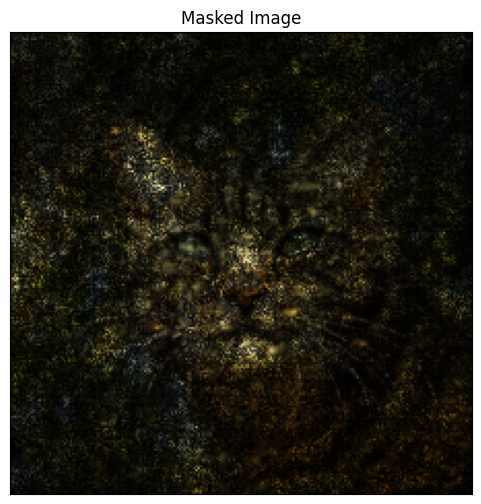

<ipython-input-14-765b3b10c329>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=matplotlib.cm.get_cmap('plasma'),


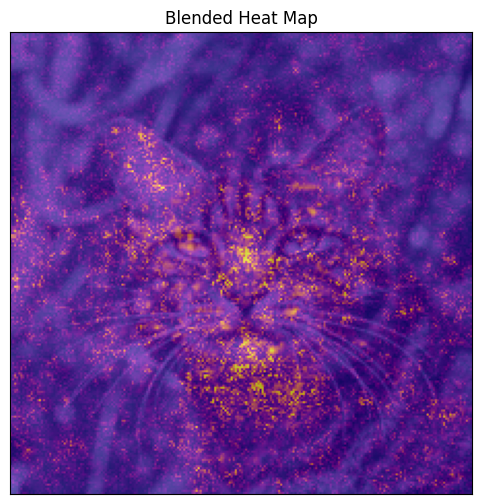

<ipython-input-14-765b3b10c329>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=matplotlib.cm.get_cmap('plasma'),


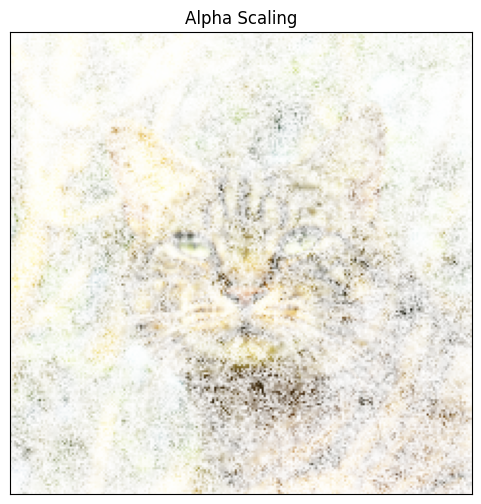

In [14]:
### COMPLETE ~15 lines expected ###
# Show masked_image
_ = viz.visualize_image_attr(np.transpose(attributions_vg.squeeze().cpu().detach().numpy(), (1,2,0)),
                             orig_img,
                             method="masked_image", title="Masked Image", sign = 'positive',
                             cmap=matplotlib.cm.get_cmap('plasma'),
)

# Show blended_heatmap
_ = viz.visualize_image_attr(np.transpose(attributions_vg.squeeze().cpu().detach().numpy(), (1,2,0)),
                             orig_img,
                             method="blended_heat_map", title="Blended Heat Map", alpha_overlay = 0.7,
                             sign = 'positive',
                             cmap=matplotlib.cm.get_cmap('plasma'),
)

# Show alpha scaling
_ = viz.visualize_image_attr(np.transpose(attributions_vg.squeeze().cpu().detach().numpy(), (1,2,0)),
                             orig_img,
                             method="alpha_scaling", title="Alpha Scaling", sign = 'positive',
                             cmap=matplotlib.cm.get_cmap('plasma'),
)

viz.visualize_image_attr_multiple
--------------------------------

This is a variant of the previous visualization method, in which the parameters `signs`, `methods`  and `titles` support also a list to plot many visualization at the same time. Try to do all previous plots in a single one, passing to the previous function the following arguments:

*   `methods=["original_image", "masked_image", "blended_heat_map", "alpha_scaling"]`
*   `signs=["all", "positive", "positive", "positive"]`
*   `titles=["Original", "Image masking", "Blended heat map", "Alpha scaling"]`


As you can notice we also require to plot the original image for comparison.


<ipython-input-28-9e38f50183ec>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=matplotlib.cm.get_cmap('plasma'), alpha_overlay = 0.7,


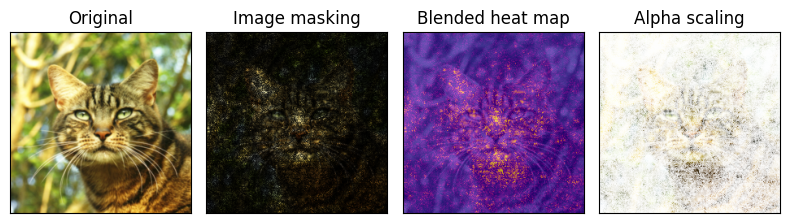

In [28]:
### COMPLETE ~ 6 lines expected ###
methods=["original_image", "masked_image", "blended_heat_map", "alpha_scaling"]
signs=["all", "positive", "positive", "positive"]
titles=["Original", "Image masking", "Blended heat map", "Alpha scaling"]

# Show images
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_vg.squeeze().cpu().detach().numpy(), (1,2,0)),
                             orig_img,
                             methods=methods,
                             signs=signs,
                             cmap=matplotlib.cm.get_cmap('plasma'), alpha_overlay = 0.7,
                             titles=titles
)

Perturbation-based methods
==================================

Gradient-based attribution methods compute the output changes with respect to the input by backpropagation of the output loss.
*Perturbation-based attribution* methods, instead, take a direct approach by
introducing changes to the input and actually measuring the effect on the output.

[Occlusion](https://captum.ai/api/occlusion.html)[1], in particular,
performs the following steps:
* It selects a patch $W\in R^{W_w\times H_w \times 3}$ initialized to $[0.5, 0.5, 0.5]$ (gray color)
* It subsequently replace sections of the input image with this patch
* It examine the effect on the output signal:
    - A prediction score decrease implies that masked pixels were *positively* important
    - A prediction score increase implies that masked pixels were *negatively* important

As you may guess, it is computationally more expensive.

<small>[1] Zeiler, M. D., & Fergus, R. (2014). Visualizing and understanding convolutional networks. In Computer Vision-ECCV 2014: 13th European Conference.</small>



Below, you have to try the Occlusion attribution. Similarly to configuring a
convolutional neural network, you must specify:
* the sliding_window_shapes=(3,W_w, H_w) (e.g., (3,15,15))
* stride length to determine the spacing of individual measurements (e.g., stride=(3, 8, 8) .

Again we will visualize the output of our Occlusion attribution
with `visualize_image_attr_multiple()`, showing heat maps of both
positive and negative attribution by region, and by masking the original
image with the positive attribution regions. The masking gives a very
instructive view of what regions of our cat photo the model found to be
most "cat-like".


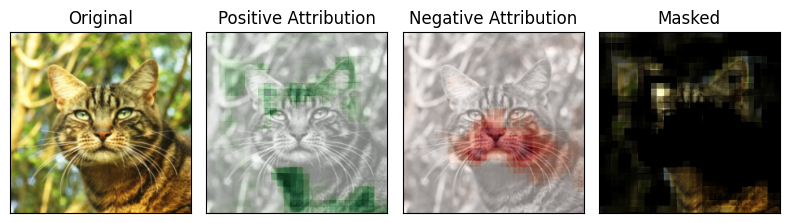

In [34]:
occlusion = Occlusion(model)

### COMPLETE ~ 5 lines expected ###
attributions_occ = occlusion.attribute(input_img,
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15,15),
                                       strides=(3, 8, 8))


_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      orig_img,
                                      ["original_image", "blended_heat_map", "blended_heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                     )

Again, we see greater significance placed on the region of the image
that contains the cat, this time particularly around the ears. The muzzle (previously important) seems to be negatively important with Occlusion.

This is most likely due to the fact that the Occlusion method is an approximation and that we are using a big patch. Try to reduce the patch dimension as well as the stride to get better results.  


GradCAM
---------------------------------

GradCAM computes the gradients of the target output with respect to the
given layer (normally the last convolutional layer), it averages for each output channel,
and multiplies the average gradient for each channel by the layer
activations.
GradCAM is designed for convnets; since the activity of convolutional layers often maps spatially to the input, GradCAM attributions are often upsampled
and used to mask the input.

For [`LayerGradCam`](https://captum.ai/api/layer.html#gradcam) (the name of GradCAM in Captum), in addition to the model, you must specify a hidden layer within the model that you wish to examine. Check the following model summary to find the name of the last convolutional layer.

As previously, when using `.attribute()`, recall to specify the target class of interest.



In [35]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

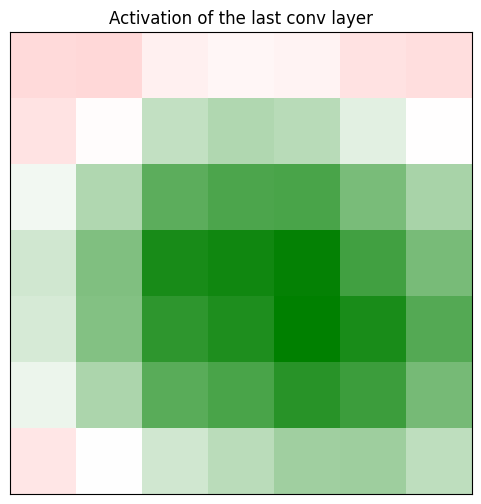

In [37]:
### COMPLETE ~ 2 lines expected ###
layer_gradcam = LayerGradCam(model, model.layer4[1].conv2)
attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)

_ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                             sign="all",
                             title="Activation of the last conv layer")

We'll use the convenience method `interpolate()` of
`LayerGradCam` to upsample this attribution data, to compare it with the original
image. As previously, plot the original image, the blended heatmap of the positive and negative attributions, and the masked image.


torch.Size([1, 1, 7, 7])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


<ipython-input-38-377645ba2ed4>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=matplotlib.cm.get_cmap('plasma'), alpha_overlay = 0.7,


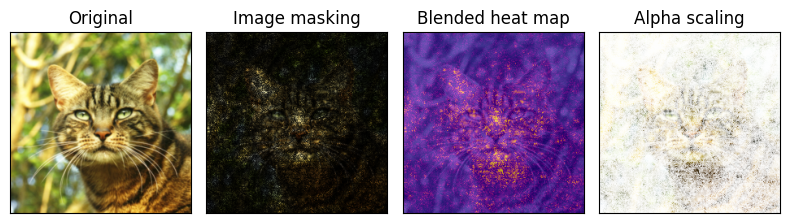

In [38]:
upsamp_attr_lgc = LayerGradCam.interpolate(attributions_lgc, input_img.shape[2:])

print(attributions_lgc.shape)
print(upsamp_attr_lgc.shape)
print(input_img.shape)


### COMPLETE ~5 lines expected ###
methods=["original_image", "masked_image", "blended_heat_map", "alpha_scaling"]
signs=["all", "positive", "positive", "positive"]
titles=["Original", "Image masking", "Blended heat map", "Alpha scaling"]

# Show images
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_vg.squeeze().cpu().detach().numpy(), (1,2,0)),
                             orig_img,
                             methods=methods,
                             signs=signs,
                             cmap=matplotlib.cm.get_cmap('plasma'), alpha_overlay = 0.7,
                             titles=titles
)


YOUR TURN!
=========

Now it is your turn to write everything from scratch. You have to provide visualization for the following methods:
*   [Input$\times$Gradient](https://captum.ai/api/input_x_gradient.html)
*   [Integrated Gradient](https://captum.ai/docs/extension/integrated_gradients)
*   [LIME](https://captum.ai/api/lime.html)

For the first two methods check whether using SmoothGrad (a.k.a. [NoiseTunnel](https://captum.ai/api/noise_tunnel.html) in Captum) improves the visualization.

Optionally, visualize also the explanations for the other images provided.

*Note* : Since Input$\times$Gradient methods already combine the gradient with the input, don't plot the attribution over the image ("blended_heat_map") but rather only the positive attribution with the "heat_map" method and the masked input.


*Note2* : In LIME, the attribution function requires the superpixels to train of the intepretable function (parameter `feature_mask` of LIME `attr` method). To get the superpixels masks you can use the following snippet. You will need to play with the parameter of both the `slic` function and the `attribute` function to extract a nice visualization.


```
from skimage.segmentation import slic, mark_boundaries

# extracting super pixels
feature_mask = slic(orig_img)

# map segment IDs to feature group IDs
fig = plt.figure("Superpixels")
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(orig_img, feature_mask))
plt.axis("off")
plt.show()

print('Feature mask IDs:', np.unique(feature_mask).tolist())
print('Feature mask', feature_mask)
```




## Input x Gradient



### With SmoothGrad

## Integrated Gradients


### With SmoothGrad



## LIME